# 画像メディア工学７回目
## 7. ２値画像処理（収縮・膨張と背景差分）
### ライブラリの読み込み（おまじない）

In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Google colaboratoryで利用する場合の画像のアップロード
img06.pngをアップしてください．ドラッグ＆ドロップでも構いません．

https://github.com/yamazoe/ImageMediaProcessing/raw/main/img/img06.png

In [2]:
# from google.colab import files
# uploaded_file = files.upload()

### 画像読み込み
img06.pngは、２値化済．一般に，背景は黒(0)，前景は白(255)で表現される．

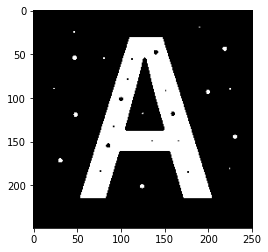

In [3]:
img = cv2.imread('img06.png', 0)  # モノクロ画像として読み込み
plt.imshow(img, cmap='gray', vmin = 0, vmax = 255);

### 収縮処理
収縮処理には，OpenCVのcv2.erode()を利用する．
kernelによるフィルタリングを行い，kernel中の1の画素の場所のいずれかに**背景が含まれれば背景**と判断するので，前景部分が収縮する．
ここでも，3x3の全てが1のフィルタを用いているので，8近傍のいずれかに背景を含むと背景となる．
iterationsは，処理の回数．

収縮処理を行うと背景中のノイズが除去され，前景中のノイズは大きくなる．
（iterations=1で除去しきれないノイズは，iterationsを大きくする，またはkernelを大きくすると除去できる）

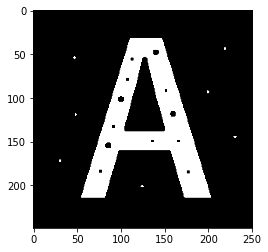

In [4]:
kernel = np.ones((3,3))
res = cv2.erode(img, kernel, iterations=1)
plt.imshow(res, cmap='gray', vmin = 0, vmax = 100);

### 膨張処理
膨張処理には，OpenCVのcv2.dilate()を利用する．
kernelによるフィルタリングを行い，kernel中の1の画素の場所のいずれかに**前景が含まれれば前景**と判断するので，前景部分が膨張する．
ここでは，3x3の全てが1のフィルタを用いているので，8近傍のいずれかに前景を含むと前景となる．
iterationsは，処理の回数．

膨張処理を行うと前景中のノイズが除去され，背景中のノイズは大きくなる．（iterations=1で除去しきれないノイズは，iterationsを大きくする，またはkernelを大きくすると除去できる）

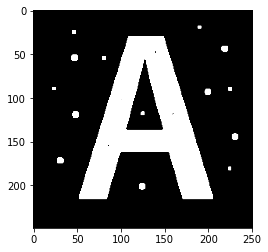

In [5]:
kernel = np.ones((3,3))
res = cv2.dilate(img, kernel, iterations=1)
plt.imshow(res, cmap='gray', vmin = 0, vmax = 100);

### オープニング処理
収縮の後に膨張を行う処理．cv2.erode()，cv2.dilate()を用いても良いが，cv2.morphologyEx()を用いると一行で実行できる．

前景の形状はほぼ変わらずに，背景のノイズ除去ができる．

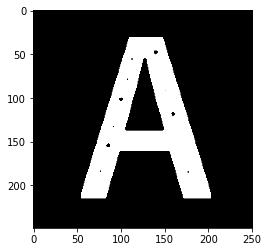

In [6]:
kernel = np.ones((5,5))
res = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# erode, dilateを用いる場合
#res = cv2.erode(img, kernel, iterations=1)
#res = cv2.dilate(res, kernel, iterations=1)

plt.imshow(res, cmap='gray', vmin = 0, vmax = 100);

### クロージング処理
膨張の後に収縮を行う処理．
cv2.erode()，cv2.dilate()を用いても良いが，cv2.morphologyEx()を用いると一行で実行できる（引数が異なる）．

前景の形状はほぼ変わらずに，前景中のノイズ除去ができる．

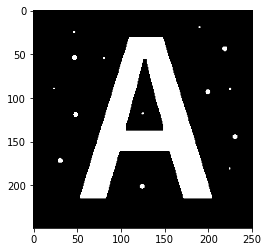

In [7]:
kernel = np.ones((5,5))
res = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

# erode, dilateを用いる場合
#res = cv2.dilate(img, kernel, iterations=1)
#res = cv2.erode(res, kernel, iterations=1)

plt.imshow(res, cmap='gray', vmin = 0, vmax = 100);

### 課題
以下のコードで，ごく単純な背景差分結果が得られるので，

*   閾値
*   収縮・膨張処理

を適切に追加・修正し，前のロボット・置物のみが抽出できるようにしてください．収縮・膨張処理については，オープニング・クロージング処理ためのカーネルのサイズを適切に変更してください．

実行前には，課題用のファイル（img07a.jpg, img07b.jpg）をアップしてください．

https://github.com/yamazoe/ImageMediaProcessing/raw/main/img/img07a.jpg

https://github.com/yamazoe/ImageMediaProcessing/raw/main/img/img07b.jpg

※ きちんと物体部分のみを切り出すには結構大変ですので，多少穴が開いたり，周辺が残ったりすると思います．

In [8]:
# from google.colab import files
# uploaded_file = files.upload()

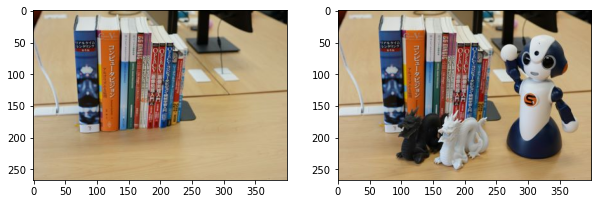

In [9]:
img_a = cv2.imread('img07a.jpg')  # 背景画像の読み込み
img_b = cv2.imread('img07b.jpg')  # 人物画像の読み込み

# RGBの順番の入れ替え
img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img_a)
plt.subplot(122)
plt.imshow(img_b)

### 背景差分画像の計算（課題その１）

前のロボット・置物のみが抽出できるように，適切な閾値を決定してください．

Colabを利用する場合，右のスライダーを利用できます．


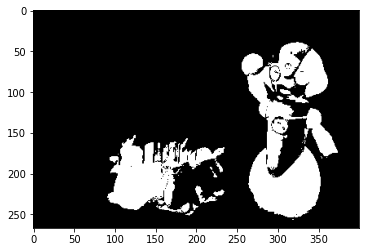

In [14]:
# @title 背景差分計算のための閾値 `thresh` の設定{ run: "auto" }
# 色の違いの計算（RGBそれぞれの差分を計算し，絶対値の平均を計算）
img_absdiff = np.abs(img_a.astype(np.float32) - img_b.astype(np.float32))
img_absdiff_gray = (img_absdiff[:, :, 0] + img_absdiff[:, :, 1] + img_absdiff[:, :, 2]) / 3.0

# 色の違いが大きい部分を前景とする
thresh = 40 # @param {type:"slider", min:0, max:255, step:1}
height, width = img_absdiff_gray.shape
img_mask = np.zeros((height, width), dtype=np.uint8)
img_mask[img_absdiff_gray > thresh] = 255

plt.imshow(img_mask, cmap='gray', vmin = 0, vmax = 255);

### オープニング・クロージング処理（課題その２）

ロボット・置物部分ができるだけきれいに抜き出せるように，`size_o`, `size_c` を適切に決定してください．

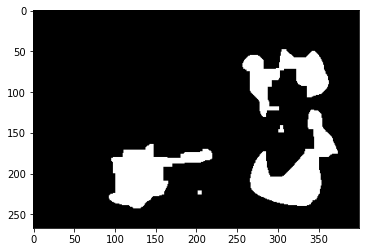

In [11]:
size_o = 4 # オープニング用のカーネルサイズ
kernel_o = np.ones((size_o, size_o))
size_c = 15 # クロージング用のカーネルサイズ
kernel_c = np.ones((size_c, size_c))

img_mask_opened = cv2.morphologyEx(img_mask, cv2.MORPH_OPEN, kernel_o)  # オープニング
img_mask_morphologied = cv2.morphologyEx(img_mask_opened, cv2.MORPH_CLOSE, kernel_c)  # クロージング

plt.imshow(img_mask_morphologied, cmap='gray', vmin=0, vmax=255);

### 背景の合成
最後に，別の背景画像と合成します．
実行前には，課題用のファイル（img07c.png）をアップしてください．

https://github.com/yamazoe/ImageMediaProcessing/raw/main/img/img07c.png

※合成用の画像データには，以下のPixabayの画像を利用しています．

https://pixabay.com/ja/illustrations/赤-クリスマスツリー-クリスマス-2892235/

In [12]:
# from google.colab import files
# uploaded_file = files.upload()

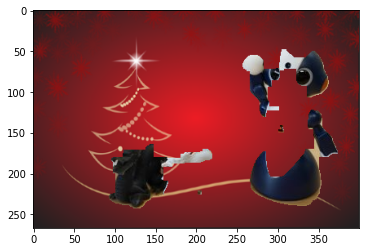

In [13]:
# 背景ファイルを読み込みとRGBの順番の入れ替え
img_c = cv2.imread('img07c.png')  # 合成する背景の画像
img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)
img_c = cv2.resize(img_c, (width, height))

# 背景の合成
img_merge = np.zeros((height, width, 3), dtype=np.uint8)
img_merge[:, :, 0] = np.where(img_mask_morphologied == 0, img_c[:, :, 0], img_b[:, :, 0])
img_merge[:, :, 1] = np.where(img_mask_morphologied == 0, img_c[:, :, 1], img_b[:, :, 1])
img_merge[:, :, 2] = np.where(img_mask_morphologied == 0, img_c[:, :, 2], img_b[:, :, 2])

plt.imshow(img_merge)